In [ ]:
''' IMPORTAR INSTALAR LIBRERIAS '''

In [1]:
pip install catboost

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 3.9/150.0 MB 39.0 MB/s eta 0:00:04
   --- ------------------------------------ 11.3/150.0 MB 35.2 MB/s eta 0:00:04
   ----- ---------------------------------- 18.9/150.0 MB 35.1 MB/s eta 0:00:04
   ------- -------------------------------- 28.0/150.0 MB 38.6 MB/s eta 0:00:04
   --------- ------------------------------ 35.7/150.0 MB 38.4 MB/s eta 0:00:03
   ----------- ---------------------------- 43.8/150.0 MB 38.1 MB/s eta 0:00:03
   ------------- -------------------------- 51.9/150.0 MB 38.0 MB/s eta 0:00:03
   ---------------- ----------------------- 60.0/150.0 MB 37.9 MB/s eta 0:00:03
   ------------------ --------------------- 68.2/150.0 MB 37.8 MB/s eta 0:00:03
   -------------------- ------------------- 76.0/150.0 MB 38.2 MB/s eta 0:00:02
   --------------------- ------------------ 82.3/150.0 MB 3

In [5]:
# gestión de datos
import numpy as np
import pandas as pd

# fechas
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# metricas
import sklearn.metrics as metrics

# interpretabilidad
import shap

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

c:\Users\rafas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
''' DATOS '''

' DATOS '

In [15]:
df = pd.read_csv('./DATA/viviendas_regresion_basica.csv')

Nuestro cliente nos pide que le digamos el precio al que podemos esperar vender las 3 últimas viviendas que acaban de entrar en la base de datos, y con qué margen de seguridad nos movemos. Para ello, nos dan los datos de las viviendas que tienen en su base de datos.

In [16]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0,1.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0,1.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0,1.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6998,viv_6999,128.0,3,5,1979-01-01,NaN,0,1.3,317000.0,31700.0,0.0
6999,viv_7000,77.0,4+,7,1996-01-01,ext,0,1.5,177000.0,17700.0,0.0
7000,viv_7001,128.0,3,6,2022-01-01,ext,0,0.7,NaN,NaN,NaN
7001,viv_7002,93.0,4+,9,1988-01-01,NaN,0,1.5,NaN,NaN,NaN


In [17]:
df_pred = df.tail(3)

In [18]:
df_pred

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
7000,viv_7001,128.0,3,6,2022-01-01,ext,0,0.7,NaN,NaN,NaN
7001,viv_7002,93.0,4+,9,1988-01-01,NaN,0,1.5,NaN,NaN,NaN
7002,viv_7003,68.0,2,3,1972-01-01,NaN,0,0.7,NaN,NaN,NaN


In [19]:
df = df.drop(df.tail(3).index)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  7000 non-null   object 
 1   superficie   6990 non-null   float64
 2   num_hab      7000 non-null   object 
 3   distancia    7000 non-null   int64  
 4   fecha_const  7000 non-null   object 
 5   parking      4763 non-null   object 
 6   premiada     7000 non-null   int64  
 7   tam_buzon    7000 non-null   float64
 8   precio       7000 non-null   float64
 9   impuestos    7000 non-null   float64
 10  vendida      7000 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 601.7+ KB


In [24]:
df["vendida"].value_counts()

vendida
1.0    5000
0.0    2000
Name: count, dtype: int64

In [ ]:
''' Como el objetivo de nuestro ejercicio es predecir un precio en el que SI se van a vender nuestras viviendas, eliminamos todas aquellas que no han sido vendidas'''
''' Si por el contrario nuestro objetivo sería predecir si la vivienda se va a vender o no se va a vender, no habria que eliminar nada '''

In [26]:
df = df[df["vendida"] == 1]

In [ ]:
df.reset_index(drop=True, inplace=True) # el drop true es para eliminar el antiguo index

In [29]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0,1.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0,1.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0,1.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,viv_6988,130.0,3,7,1996-01-01,NaN,0,1.9,286000.0,28600.0,1.0
4996,viv_6989,120.0,3,8,2022-01-01,ext,0,1.0,299000.0,29900.0,1.0
4997,viv_6990,76.0,4+,7,2006-01-01,ext,0,0.5,245000.0,24500.0,1.0
4998,viv_6993,128.0,3,8,2022-01-01,NaN,0,1.3,276000.0,27600.0,1.0


In [30]:
# eliiminamos la columna vendida porque ya no tiene sentido tenerla
del(df["vendida"])
del(df_pred["vendida"])

In [31]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0
2,viv_3,80.0,4+,4,1970-01-01,NaN,0,1.0,233000.0,23300.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0
4,viv_5,86.0,2,8,1999-01-01,NaN,0,1.2,210000.0,21000.0
...,...,...,...,...,...,...,...,...,...,...
4995,viv_6988,130.0,3,7,1996-01-01,NaN,0,1.9,286000.0,28600.0
4996,viv_6989,120.0,3,8,2022-01-01,ext,0,1.0,299000.0,29900.0
4997,viv_6990,76.0,4+,7,2006-01-01,ext,0,0.5,245000.0,24500.0
4998,viv_6993,128.0,3,8,2022-01-01,NaN,0,1.3,276000.0,27600.0


In [34]:
df.isnull().sum()

id_vivienda       0
superficie       10
num_hab           0
distancia         0
fecha_const       0
parking        1580
premiada          0
tam_buzon         0
precio            0
impuestos         0
dtype: int64

In [ ]:
#eliminamos viviendas sin superficie ya que son pocas y la sup es un dato muy relevante en el precio
df.drop(df[df["superficie"].isnull()].index, inplace=True)

In [41]:
df.isnull().sum()

id_vivienda       0
superficie        0
num_hab           0
distancia         0
fecha_const       0
parking        1580
premiada          0
tam_buzon         0
precio            0
impuestos         0
dtype: int64

In [44]:
df["parking"].unique()

array(['ext', nan, 'int'], dtype=object)

In [ ]:
df["parking"].value_counts()

parking
ext    0.51085
int    0.48915
Name: proportion, dtype: float64

In [45]:
# inputamos los nulo de parking como que la vivienda no tiene parking
df["parking"].fillna("No Tiene",inplace=True)

In [47]:
df.isnull().sum().sum()

0

In [49]:
df_pred["parking"].fillna("No Tiene",inplace=True)

In [51]:
del(df_pred["precio"])

In [53]:
print(df.head(1))
print(df_pred.head(1))

  id_vivienda  superficie num_hab  distancia fecha_const parking  premiada  \
0       viv_1        65.0       1          7  1991-01-01     ext         0   

   tam_buzon    precio  impuestos  
0        0.9  166000.0    16600.0  
     id_vivienda  superficie num_hab  distancia fecha_const parking  premiada  \
7000    viv_7001       128.0       3          6  2022-01-01     ext         0   

      tam_buzon  impuestos  
7000        0.7        NaN  


In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
superficie,4990.0,96.931663,20.044797,60.0,80.0,98.0,114.0,130.0
distancia,4990.0,5.408417,2.786865,1.0,3.0,5.0,8.0,10.0
premiada,4990.0,0.000200,0.014156,0.0,0.0,0.0,0.0,1.0
tam_buzon,4990.0,1.243507,0.431958,0.5,0.9,1.2,1.6,2.0
precio,4990.0,245515.230461,47513.575494,129000.0,209000.0,243000.0,282000.0,350000.0
impuestos,4990.0,24551.523046,4751.357549,12900.0,20900.0,24300.0,28200.0,35000.0


In [56]:
df.reset_index(inplace=True, drop=True)

In [57]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,premiada,tam_buzon,precio,impuestos
0,viv_1,65.0,1,7,1991-01-01,ext,0,0.9,166000.0,16600.0
1,viv_2,97.0,4+,8,1994-01-01,ext,0,1.8,279000.0,27900.0
2,viv_3,80.0,4+,4,1970-01-01,No Tiene,0,1.0,233000.0,23300.0
3,viv_4,73.0,1,1,1983-01-01,ext,0,1.1,182000.0,18200.0
4,viv_5,86.0,2,8,1999-01-01,No Tiene,0,1.2,210000.0,21000.0
...,...,...,...,...,...,...,...,...,...,...
4985,viv_6988,130.0,3,7,1996-01-01,No Tiene,0,1.9,286000.0,28600.0
4986,viv_6989,120.0,3,8,2022-01-01,ext,0,1.0,299000.0,29900.0
4987,viv_6990,76.0,4+,7,2006-01-01,ext,0,0.5,245000.0,24500.0
4988,viv_6993,128.0,3,8,2022-01-01,No Tiene,0,1.3,276000.0,27600.0


<Axes: xlabel='precio', ylabel='Density'>

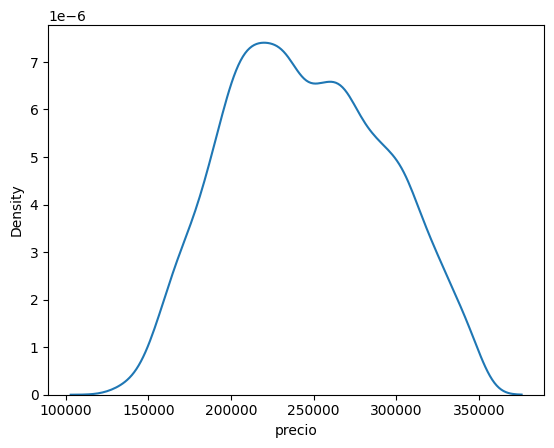

In [58]:
# visualizamos la distribución nuestro Target: precio
sns.kdeplot(data=df, x="precio")

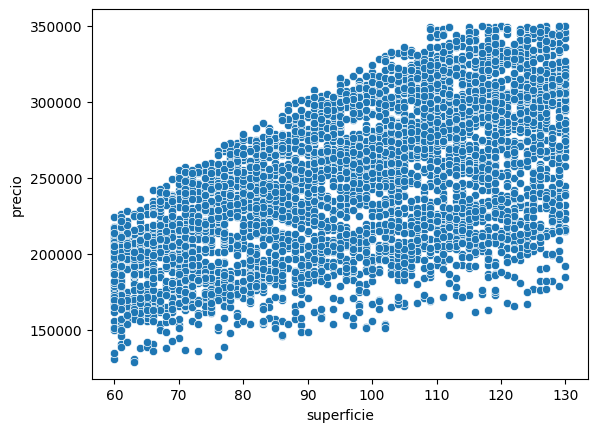

In [59]:
sns.scatterplot(data=df, x='superficie', y='precio')
plt.show()

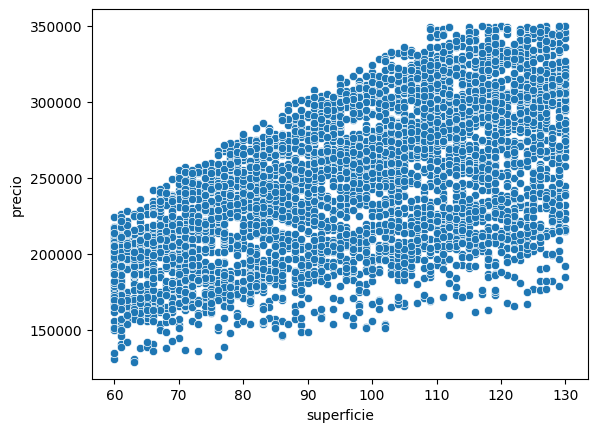

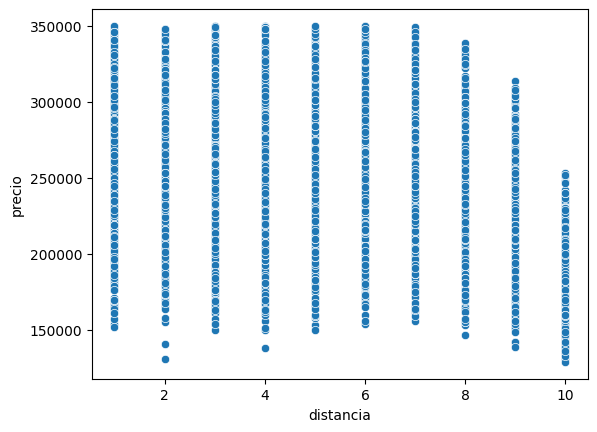

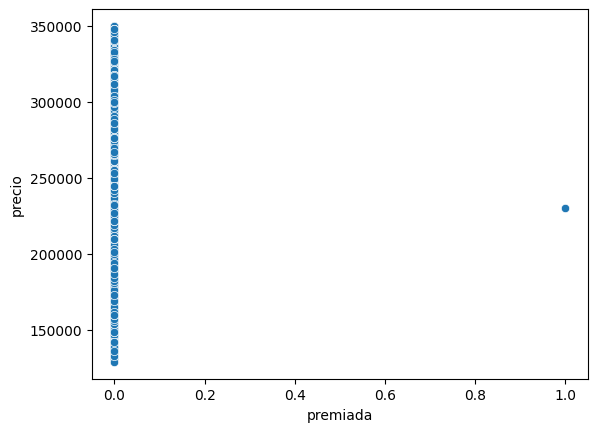

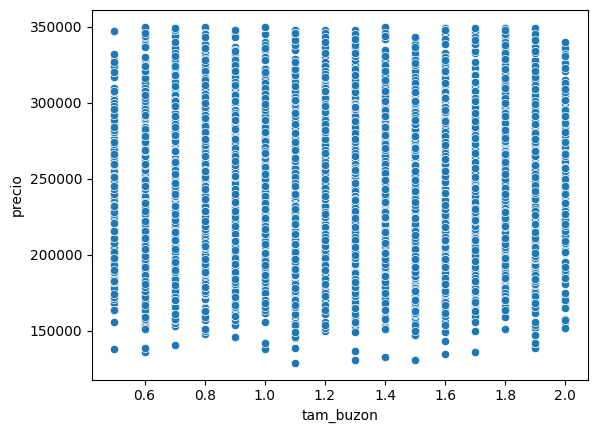

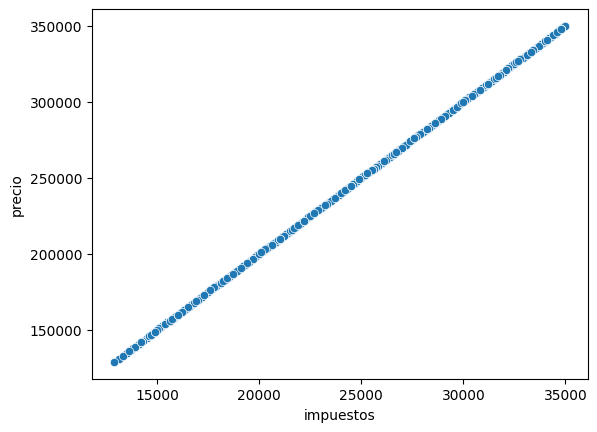

In [63]:
for i in df:
    if i != 'precio' and df[i].dtype.kind  in ["i","f"]:
        sns.scatterplot(data=df, x=i, y='precio')
        plt.show()

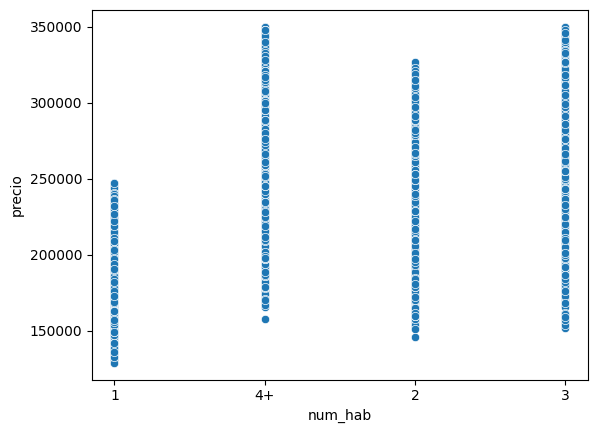

In [60]:
sns.scatterplot(data=df, x='num_hab', y='precio')
plt.show()

## PREPROCESSIN 

In [65]:
df.duplicated().sum()

0

<Axes: xlabel='precio'>

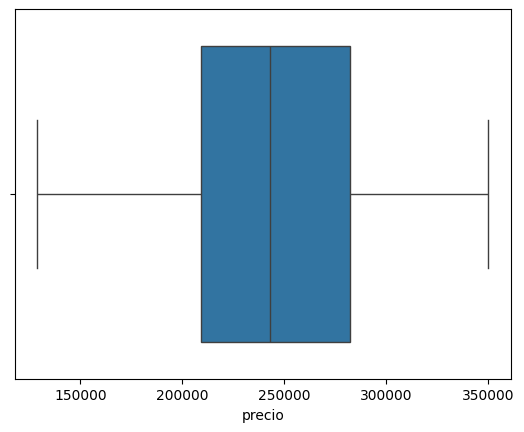

In [67]:
sns.boxplot(data= df, x="precio")

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  4990 non-null   object 
 1   superficie   4990 non-null   float64
 2   num_hab      4990 non-null   object 
 3   distancia    4990 non-null   int64  
 4   fecha_const  4990 non-null   object 
 5   parking      4990 non-null   object 
 6   premiada     4990 non-null   int64  
 7   tam_buzon    4990 non-null   float64
 8   precio       4990 non-null   float64
 9   impuestos    4990 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 390.0+ KB


In [69]:
df["num_hab"].unique()

array(['1', '4+', '2', '3'], dtype=object)

In [70]:
df["num_hab"].replace("4+","4",inplace=True)

In [71]:
df["num_hab"].unique()

array(['1', '4', '2', '3'], dtype=object)

In [72]:
# convierto a tipo int
df["num_hab"] = df["num_hab"].astype(int)

In [73]:
df["superficie"] = df["superficie"].astype(int)

In [75]:
# elimino la columna impuestos, ya que estos son un 10% sobre el valor del precio y no me aporta nada. Ademas tendria una correlacion de 1 por lo que lo eliminaría igualmente más adelante
del(df["impuestos"])
del(df_pred["impuestos"])

In [77]:
df["fecha_const"] = pd.to_datetime(df["fecha_const"], errors="coerce")
df_pred["fecha_const"] = pd.to_datetime(df_pred["fecha_const"], errors="coerce")

In [79]:
hoy = pd.Timestamp.today()

In [80]:
df["Antiguedad"] = hoy - df["fecha_const"]
df_pred["Antiguedad"] = hoy - df_pred["fecha_const"]

In [81]:
del(df["fecha_const"])
del(df_pred["fecha_const"])

In [82]:
df.head()

,id_vivienda,superficie,num_hab,distancia,parking,premiada,tam_buzon,precio,Antiguedad
0,viv_1,65,1,7,ext,0,0.9,166000.0,12530 days 19:06:33.314432
1,viv_2,97,4,8,ext,0,1.8,279000.0,11434 days 19:06:33.314432
2,viv_3,80,4,4,No Tiene,0,1.0,233000.0,20200 days 19:06:33.314432
3,viv_4,73,1,1,ext,0,1.1,182000.0,15452 days 19:06:33.314432
4,viv_5,86,2,8,No Tiene,0,1.2,210000.0,9608 days 19:06:33.314432


In [83]:
df["Antiguedad"] = df["Antiguedad"].dt.days
df_pred["Antiguedad"] = df_pred["Antiguedad"].dt.days

In [84]:
df["Antiguedad"] = df["Antiguedad"].astype(int)/365
df_pred["Antiguedad"] = df_pred["Antiguedad"].astype(int)/365

In [89]:
df["Antiguedad"] = df["Antiguedad"].astype(int)
df_pred["Antiguedad"] = df_pred["Antiguedad"].astype(int)

In [90]:
df

,id_vivienda,superficie,num_hab,distancia,parking,premiada,tam_buzon,precio,Antiguedad
0,viv_1,65,1,7,ext,0,0.9,166000.0,34
1,viv_2,97,4,8,ext,0,1.8,279000.0,31
2,viv_3,80,4,4,No Tiene,0,1.0,233000.0,55
3,viv_4,73,1,1,ext,0,1.1,182000.0,42
4,viv_5,86,2,8,No Tiene,0,1.2,210000.0,26
...,...,...,...,...,...,...,...,...,...
4985,viv_6988,130,3,7,No Tiene,0,1.9,286000.0,29
4986,viv_6989,120,3,8,ext,0,1.0,299000.0,3
4987,viv_6990,76,4,7,ext,0,0.5,245000.0,19
4988,viv_6993,128,3,8,No Tiene,0,1.3,276000.0,3
